## Data Augmentation for Bounding Boxes

In this notebook, we adapted image augmentation techniques to object detection tasks. We implemented rotation, width and height shift, and scaling of images as well as bounding boxes using OpenCV's affine transformation features. We assumed only one object (bounding box) per image.

%load_ext autoreload

%autoreload 2**Dependencies**

In [183]:
%load_ext autoreload

%autoreload 2

import numpy as np
import cv2

import utils as u
import xml.etree.ElementTree as ET

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We used dictionaries to facilitate "tests". The method in this cell apply the transformation passed as parameter. This operation is realized $n$ times. For each time, it generate a random factor (angle, scale factor, etc) according to specified in dictionary.

In [189]:
'''
Rotate image and compute new bounding box
@param image - image to be rotated
@param angle - rotation angle
@param bounding_box - original bounding box
@return: the rotated image and the new bounding box
'''
def rotate_image( image, angle, bounding_box ):
    
    # get image dimension
    img_height, img_width = image.shape[:2]
    diff =abs(img_height - img_width ) 
    image = cv2.copyMakeBorder(image,100,100,0,0,cv2.BORDER_REPLICATE)
    
    img_height, img_width = image.shape[:2]
    # get rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D( center = (img_width // 2, img_height // 2), angle = angle, scale = 1.0 )
   
    # apply transformation (ratate image) 
    rotated_image = cv2.warpAffine( image, rotation_matrix, (img_width, img_height) )
    
    # --- compute new bounding box ---
    # Apply same transformation to the four bounding box corners
    rotated_point_A = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[1]+100, 1] ).T )   
    rotated_point_B = np.matmul( rotation_matrix, np.array( [bounding_box[2], bounding_box[1]+100, 1] ).T )   
    rotated_point_C = np.matmul( rotation_matrix, np.array( [bounding_box[2 ], bounding_box[3]+100, 1] ).T )   
    rotated_point_D = np.matmul( rotation_matrix, np.array( [bounding_box[0], bounding_box[3]+100, 1] ).T )   
    # Compute new bounding box, that is, the bounding box for rotated object
    x = np.array( [ rotated_point_A[0], rotated_point_B[0], rotated_point_C[0], rotated_point_D[0] ] )
    y = np.array( [ rotated_point_A[1], rotated_point_B[1], rotated_point_C[1], rotated_point_D[1] ] )
    new_boundingbox = [np.min( x ).astype(int), np.min( y ).astype(int), np.max( x ).astype(int), np.max( y ).astype(int)]
    
    return rotated_image, new_boundingbox

In [185]:
def width_shift_image( image, width_shift_range, boundingbox ):
    
#     img_height, img_width = image.shape[:2]
#     diff =abs(img_height - img_width ) 
#     extd_image = cv2.copyMakeBorder(image,0,0,0,img_width,cv2.BORDER_REPLICATE)
    
    img_height, img_width = image.shape[:2]
    factor = img_width * width_shift_range
    
    M = np.float32([[1,0,factor],[0,1,0]]) 
    shifted_image = cv2.warpAffine( image, M, (img_width, img_height) )
    
    # compute new bounding box    
    shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
    shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   
    
    new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int), 
                        shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]
    
    return shifted_image, new_boundingbox, 

def height_shift_image( image, height_shift_range, boundingbox ):
    
    img_height, img_width = image.shape[:2]
    factor = height_shift_range * img_height
    
    M = np.float32([[1,0,0],[0,1,factor]]) 
    shifted_image = cv2.warpAffine(image, M, (img_width, img_height) )
    
    # compute new bounding box    
    shifted_point_A = np.matmul( M, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
    shifted_point_C = np.matmul( M, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   
    
    new_boundingbox = [ shifted_point_A[0].astype(int), shifted_point_A[1].astype(int), 
                        shifted_point_C[0].astype(int), shifted_point_C[1].astype(int) ]
    
    return shifted_image, new_boundingbox

In [186]:
def scale_image( image, scale_factor, boundingbox ):

    img_height, img_width = original_image.shape[:2]

    width = (int)(scale_factor * img_width)
    height = (int)(scale_factor * img_height)
    
    scaled_img = cv2.resize( image, (width,height) )

    scaling_marix = np.array( [ [scale_factor, 0, 0], [0, scale_factor, 0], [0, 0, scale_factor] ] )

    scaled_point_A = np.matmul( scaling_marix, np.array( [boundingbox[0], boundingbox[1], 1] ).T )   
    scaled_point_C = np.matmul( scaling_marix, np.array( [boundingbox[2], boundingbox[3], 1] ).T )   

    new_boundingbox = [ scaled_point_A[0].astype(int), scaled_point_A[1].astype(int), 
                        scaled_point_C[0].astype(int), scaled_point_C[1].astype(int) ]
    
    return scaled_img, new_boundingbox

In [187]:
t_dic = { "rotation":rotate_image, "width_shift":width_shift_image, "height_shift":height_shift_image, "scale": scale_image }
f_dic = { "rotation":(0, 90), "width_shift":(0, 0.5), "height_shift":(0, 0.5), "scale": (0.5, 1.5)}

'''
Apply the specidied transdormation n times
return: a list with all transformated images, it bounding box and the value factor used.
'''
def apply_transformation( image, bounding_box, transformation, n ):
    
    import random
    
    t_images_list = []
    
    for i in range(0, n):
        interval = f_dic[transformation]
        factor = random.uniform(interval[0], interval[1])
        img, bb = t_dic[transformation]( image, factor, bounding_box )
        t_images_list.append( (img, bb, factor) )

    return t_images_list
    

[20, 16, 525, 334]
G:\image_proccessing\data_object_detection_sample\frame1.jpg


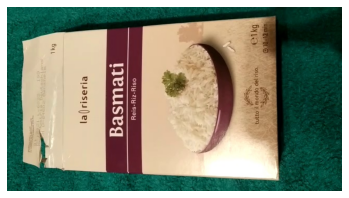

[111, 46, 510, 598]
[26, 17, 561, 614]
[152, 67, 483, 579]
[103, 43, 515, 601]
[-18, 29, 578, 573]
[79, 33, 530, 609]
[106, 44, 513, 600]
[-15, 24, 578, 583]
[84, 35, 527, 607]
[0, 16, 574, 604]
[115, 48, 508, 596]
[141, 61, 490, 585]
[21, 16, 564, 613]
[80, 33, 530, 608]
[34, 19, 557, 614]
[117, 49, 506, 596]
[269, 16, 774, 334]
[234, 16, 739, 334]
[271, 16, 776, 334]
[145, 16, 650, 334]
[152, 16, 657, 334]
[110, 16, 615, 334]
[207, 16, 712, 334]
[246, 16, 751, 334]
[205, 16, 710, 334]
[218, 16, 723, 334]
[21, 16, 526, 334]
[245, 16, 750, 334]
[131, 16, 636, 334]
[212, 16, 717, 334]
[280, 16, 785, 334]
[304, 16, 809, 334]
352
640
[20, 178, 525, 496]
20
352
352
640
[20, 27, 525, 345]
20
345
352
640
[20, 97, 525, 415]
20
352
352
640
[20, 166, 525, 484]
20
352
352
640
[20, 125, 525, 443]
20
352
352
640
[20, 157, 525, 475]
20
352
352
640
[20, 161, 525, 479]
20
352
352
640
[20, 157, 525, 475]
20
352
352
640
[20, 151, 525, 469]
20
352
352
640
[20, 161, 525, 479]
20
352
352
640
[20, 26, 525,

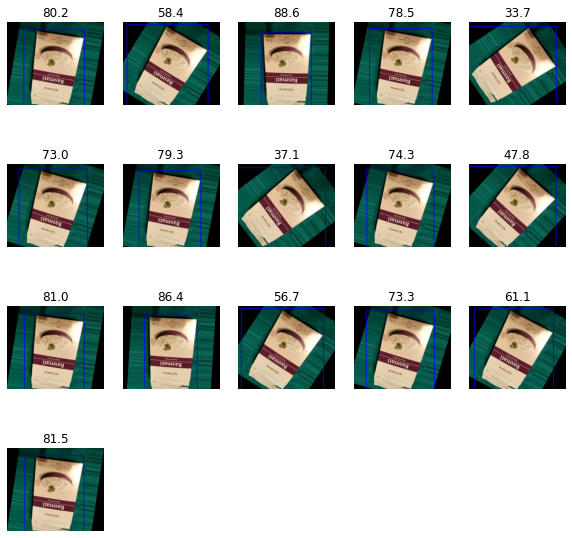

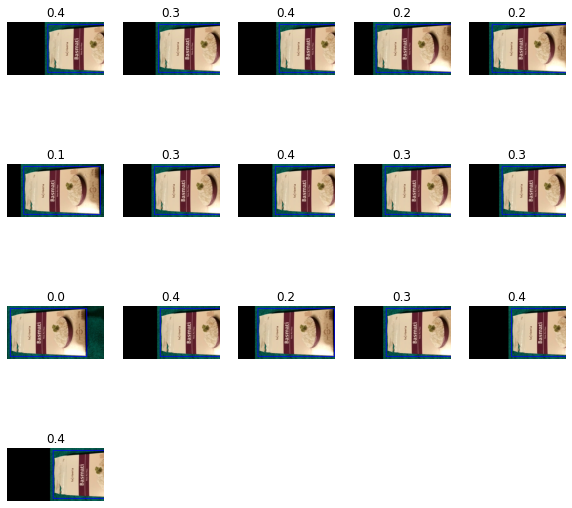

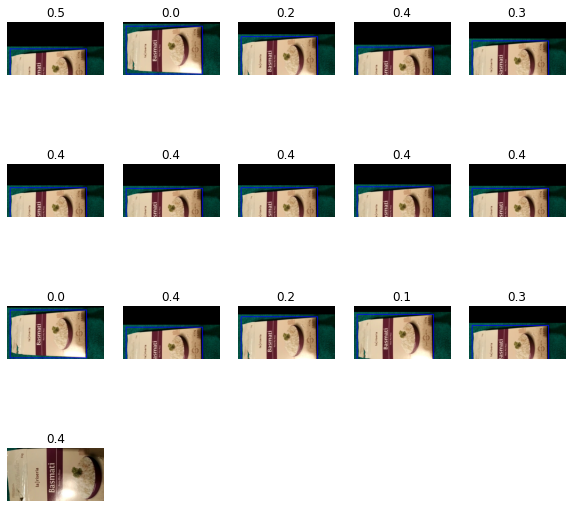

[-40, -52, 678, 604]
[29, -84, 609, 638]
[-35, 18, 673, 533]
[75, -72, 562, 626]
[38, -83, 599, 636]
[-43, -38, 681, 591]
[122, -52, 516, 606]
[-28, 39, 666, 512]
[-43, -42, 680, 594]
[63, -77, 574, 630]
[89, -67, 549, 621]
[125, -51, 513, 605]
[-30, -70, 668, 623]
[47, -81, 590, 634]
[-6, 87, 644, 463]
[-37, 10, 675, 540]
[27, 1, 663, 350]
[60, 1, 696, 350]
[7, 1, 643, 350]
[258, 1, 894, 350]
[279, 1, 915, 350]
[52, 1, 688, 350]
[122, 1, 758, 350]
[56, 1, 692, 350]
[190, 1, 826, 350]
[201, 1, 837, 350]
[317, 1, 953, 350]
[228, 1, 864, 350]
[60, 1, 696, 350]
[48, 1, 684, 350]
[104, 1, 740, 350]
[189, 1, 825, 350]
352
640
[1, 104, 637, 453]
1
352
352
640
[1, 1, 637, 350]
1
350
352
640
[1, 14, 637, 363]
1
352
352
640
[1, 70, 637, 419]
1
352
352
640
[1, 107, 637, 456]
1
352
352
640
[1, 35, 637, 384]
1
352
352
640
[1, 104, 637, 453]
1
352
352
640
[1, 138, 637, 487]
1
352
352
640
[1, 106, 637, 455]
1
352
352
640
[1, 9, 637, 358]
1
352
352
640
[1, 28, 637, 377]
1
352
352
640
[1, 28, 637, 377

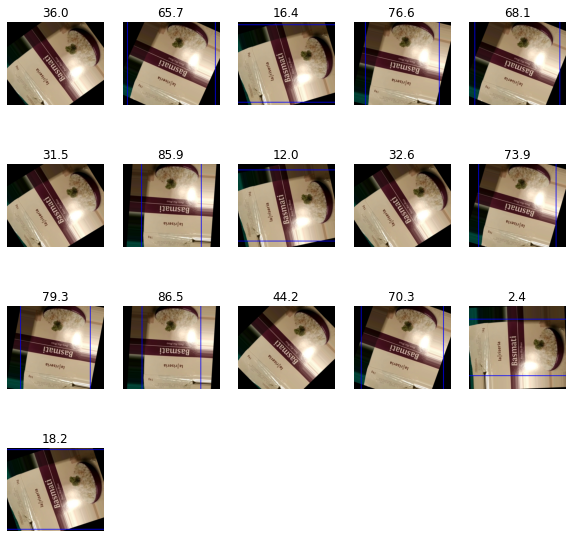

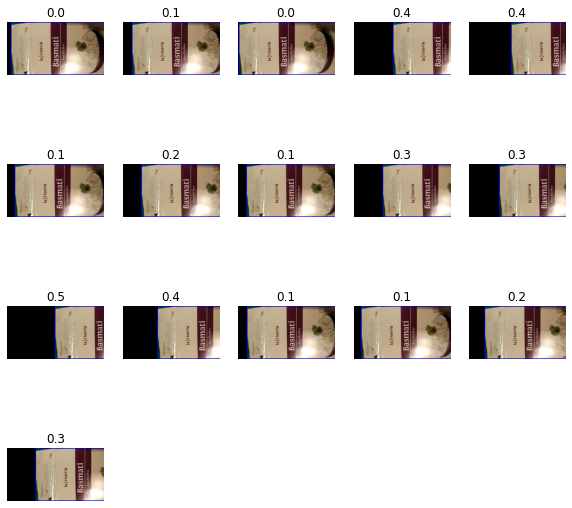

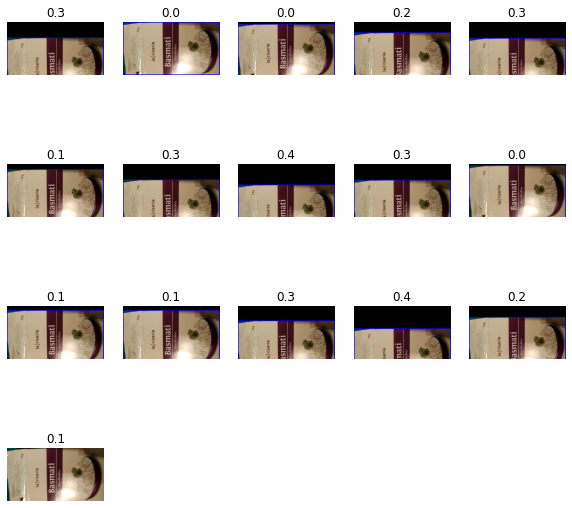

[-27, -70, 667, 626]
[-40, -47, 679, 603]
[-30, 35, 667, 520]
[91, -66, 550, 621]
[100, -62, 542, 618]
[77, -71, 565, 627]
[-36, 14, 674, 541]
[-39, -49, 679, 605]
[-27, -70, 667, 626]
[-42, -18, 681, 574]
[87, -67, 554, 623]
[46, -80, 595, 636]
[-29, -68, 669, 624]
[-41, -9, 680, 565]
[11, -84, 629, 640]
[-20, -75, 660, 631]
[174, 3, 809, 352]
[198, 3, 833, 352]
[211, 3, 846, 352]
[6, 3, 641, 352]
[21, 3, 656, 352]
[121, 3, 756, 352]
[283, 3, 918, 352]
[264, 3, 899, 352]
[78, 3, 713, 352]
[245, 3, 880, 352]
[80, 3, 715, 352]
[112, 3, 747, 352]
[230, 3, 865, 352]
[132, 3, 767, 352]
[167, 3, 802, 352]
[55, 3, 690, 352]
352
640
[1, 86, 636, 435]
1
352
352
640
[1, 149, 636, 498]
1
352
352
640
[1, 83, 636, 432]
1
352
352
640
[1, 110, 636, 459]
1
352
352
640
[1, 33, 636, 382]
1
352
352
640
[1, 53, 636, 402]
1
352
352
640
[1, 162, 636, 511]
1
352
352
640
[1, 87, 636, 436]
1
352
352
640
[1, 128, 636, 477]
1
352
352
640
[1, 34, 636, 383]
1
352
352
640
[1, 33, 636, 382]
1
352
352
640
[1, 27, 63

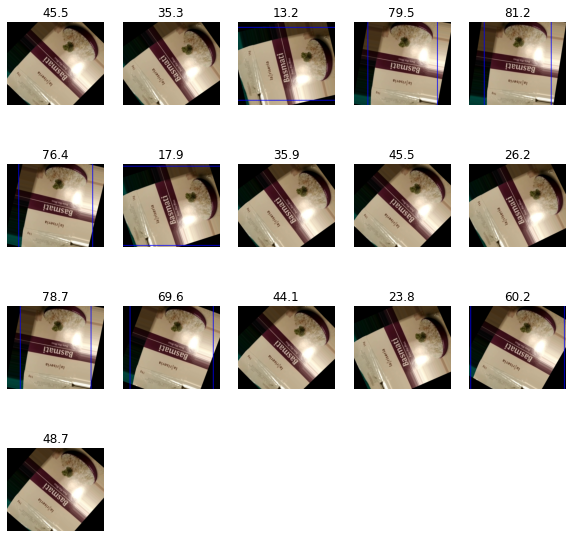

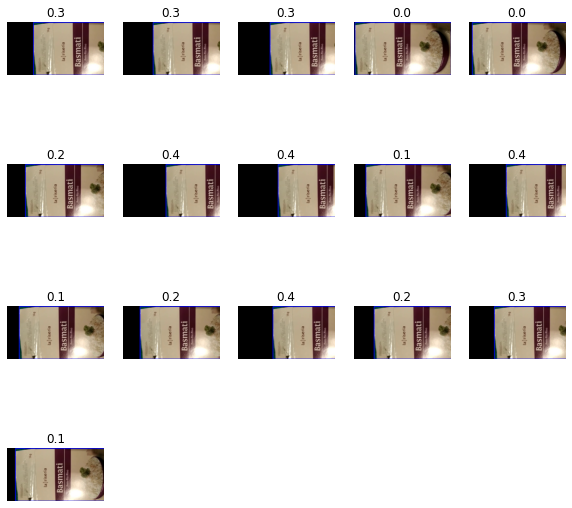

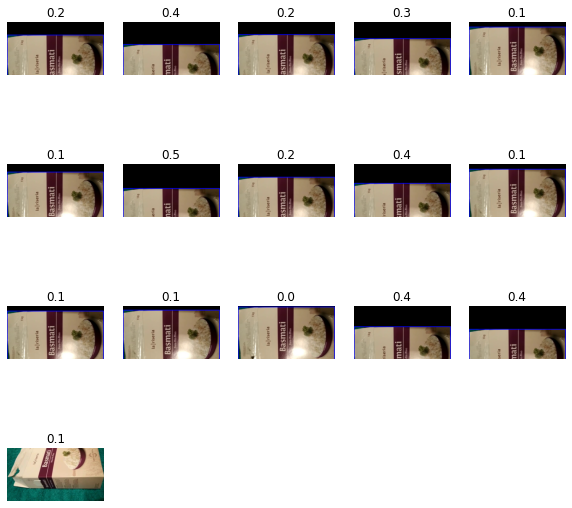

[-4, 50, 651, 422]
[43, -86, 532, 590]
[9, -87, 576, 580]
[49, -85, 525, 591]
[116, -59, 448, 584]
[-15, -74, 614, 558]
[37, -87, 540, 589]
[142, -45, 420, 576]
[-11, -78, 608, 563]
[107, -63, 458, 586]
[-2, -83, 594, 572]
[1, -85, 588, 575]
[140, -46, 422, 577]
[-27, -43, 642, 519]
[-27, -34, 646, 509]
[38, -87, 538, 590]
[136, 1, 756, 274]
[86, 1, 706, 274]
[190, 1, 810, 274]
[105, 1, 725, 274]
[248, 1, 868, 274]
[123, 1, 743, 274]
[156, 1, 776, 274]
[47, 1, 667, 274]
[69, 1, 689, 274]
[181, 1, 801, 274]
[204, 1, 824, 274]
[166, 1, 786, 274]
[115, 1, 735, 274]
[128, 1, 748, 274]
[226, 1, 846, 274]
[74, 1, 694, 274]
352
640
[20, 62, 640, 335]
20
335
352
640
[20, 8, 640, 281]
20
281
352
640
[20, 8, 640, 281]
20
281
352
640
[20, 133, 640, 406]
20
352
352
640
[20, 71, 640, 344]
20
344
352
640
[20, 33, 640, 306]
20
306
352
640
[20, 174, 640, 447]
20
352
352
640
[20, 74, 640, 347]
20
347
352
640
[20, 127, 640, 400]
20
352
352
640
[20, 176, 640, 449]
20
352
352
640
[20, 133, 640, 406]
20
35

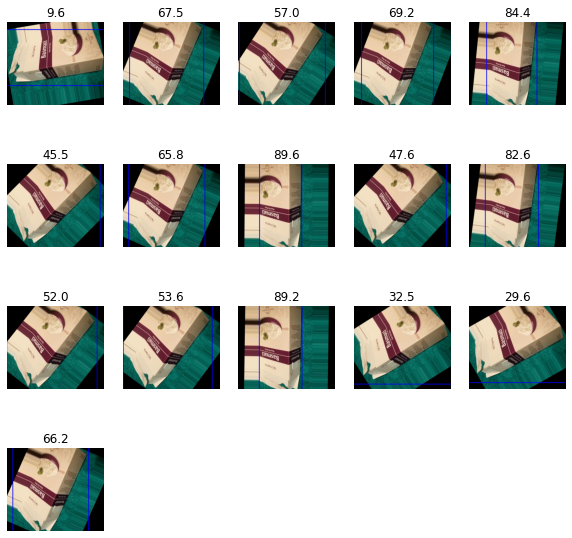

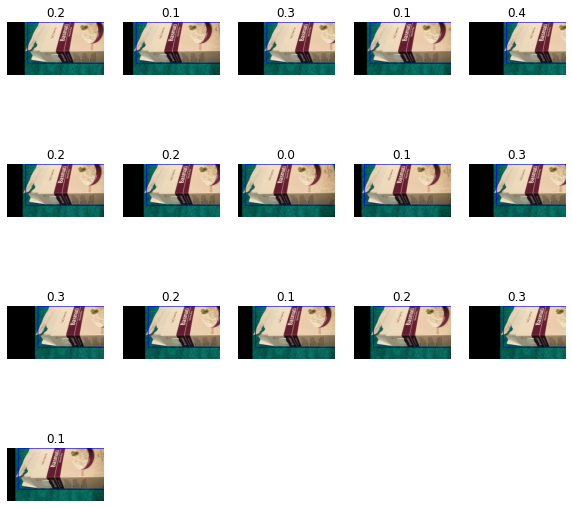

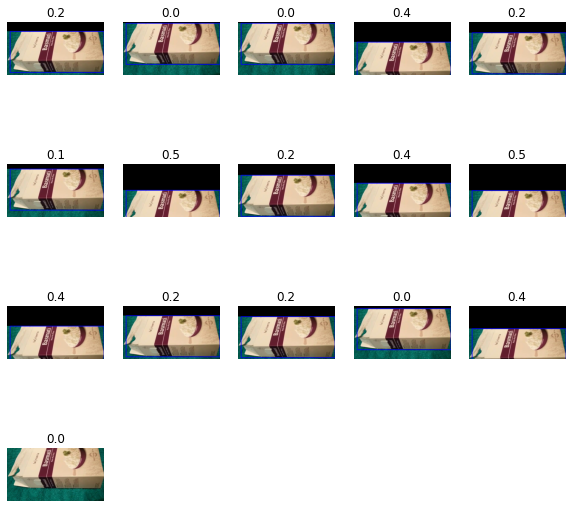

[133, -50, 431, 579]
[79, -76, 491, 590]
[-22, -64, 628, 545]
[32, -88, 547, 589]
[-26, -45, 642, 522]
[45, -86, 532, 591]
[11, -87, 574, 582]
[-22, -64, 628, 545]
[97, -68, 470, 588]
[-26, -45, 642, 522]
[75, -77, 496, 591]
[8, 78, 646, 396]
[95, -69, 473, 588]
[-23, -59, 632, 539]
[-12, 32, 654, 441]
[79, -76, 491, 590]
[115, 1, 735, 275]
[211, 1, 831, 275]
[32, 1, 652, 275]
[219, 1, 839, 275]
[277, 1, 897, 275]
[183, 1, 803, 275]
[303, 1, 923, 275]
[288, 1, 908, 275]
[121, 1, 741, 275]
[164, 1, 784, 275]
[247, 1, 867, 275]
[251, 1, 871, 275]
[52, 1, 672, 275]
[331, 1, 951, 275]
[134, 1, 754, 275]
[151, 1, 771, 275]
352
640
[20, 17, 640, 291]
20
291
352
640
[20, 50, 640, 324]
20
324
352
640
[20, 33, 640, 307]
20
307
352
640
[20, 160, 640, 434]
20
352
352
640
[20, 120, 640, 394]
20
352
352
640
[20, 5, 640, 279]
20
279
352
640
[20, 158, 640, 432]
20
352
352
640
[20, 92, 640, 366]
20
352
352
640
[20, 4, 640, 278]
20
278
352
640
[20, 32, 640, 306]
20
306
352
640
[20, 41, 640, 315]
20
315

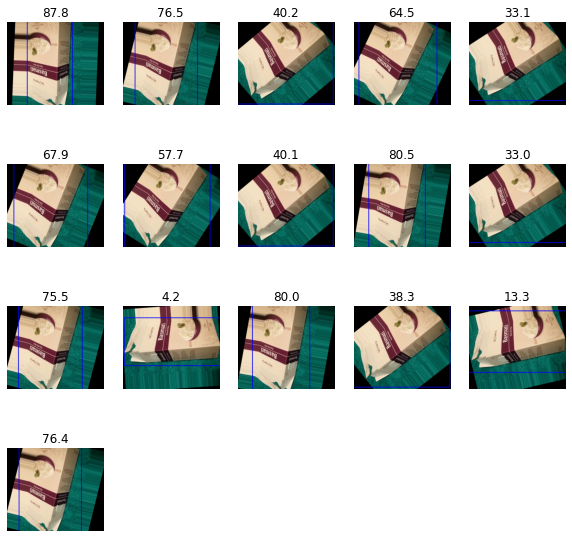

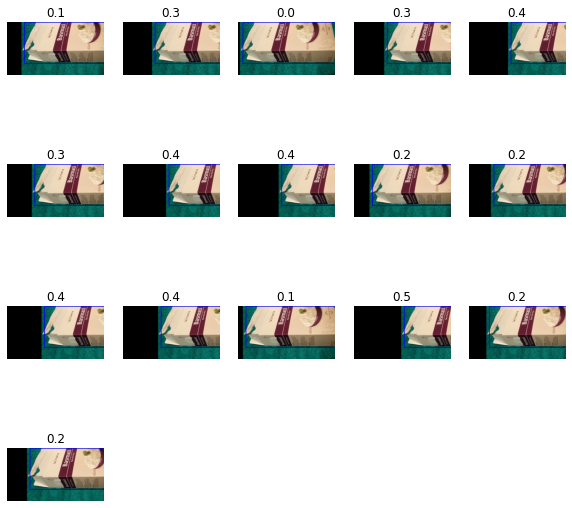

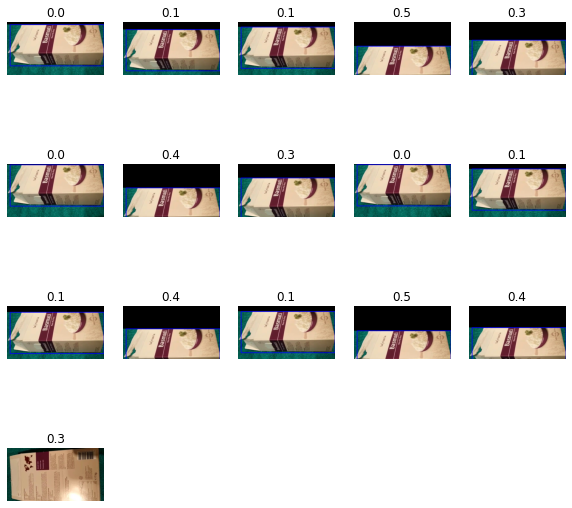

[17, -51, 641, 625]
[27, -55, 632, 627]
[-19, 6, 667, 573]
[-19, 11, 666, 568]
[147, -36, 520, 597]
[-19, 22, 665, 557]
[-10, 72, 649, 508]
[36, -57, 623, 628]
[66, -58, 597, 626]
[166, -28, 501, 587]
[0, -40, 655, 616]
[-8, 78, 647, 502]
[-4, 88, 642, 492]
[-1, 95, 639, 484]
[-1, -38, 656, 615]
[0, 100, 636, 479]
[78, 30, 686, 350]
[119, 30, 727, 350]
[91, 30, 699, 350]
[281, 30, 889, 350]
[119, 30, 727, 350]
[138, 30, 746, 350]
[21, 30, 629, 350]
[234, 30, 842, 350]
[288, 30, 896, 350]
[211, 30, 819, 350]
[170, 30, 778, 350]
[86, 30, 694, 350]
[283, 30, 891, 350]
[327, 30, 935, 350]
[123, 30, 731, 350]
[42, 30, 650, 350]
352
640
[13, 200, 621, 520]
13
352
352
640
[13, 187, 621, 507]
13
352
352
640
[13, 194, 621, 514]
13
352
352
640
[13, 161, 621, 481]
13
352
352
640
[13, 166, 621, 486]
13
352
352
640
[13, 147, 621, 467]
13
352
352
640
[13, 58, 621, 378]
13
352
352
640
[13, 139, 621, 459]
13
352
352
640
[13, 99, 621, 419]
13
352
352
640
[13, 198, 621, 518]
13
352
352
640
[13, 151, 621

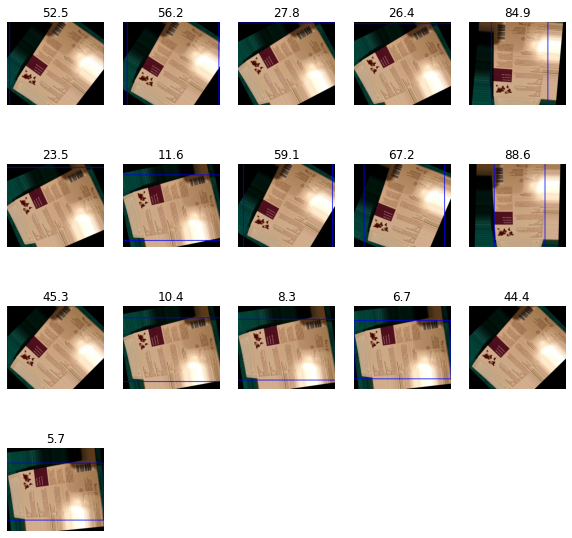

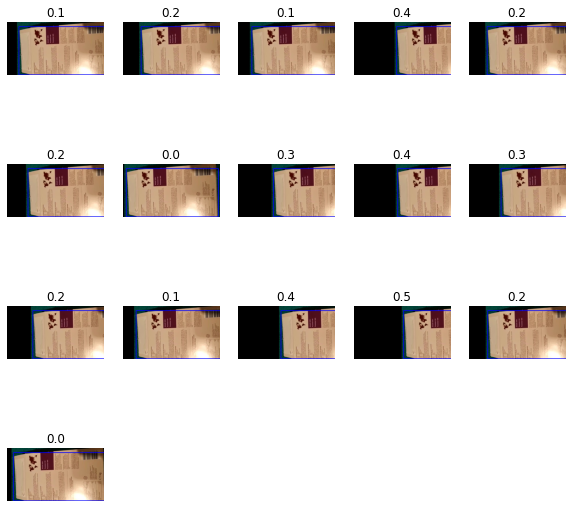

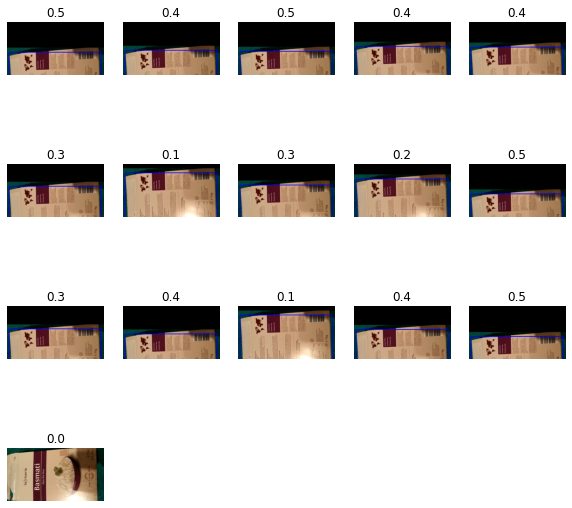

[-15, 73, 619, 487]
[-21, -47, 639, 629]
[136, -11, 506, 600]
[-11, -51, 631, 634]
[-41, -9, 650, 582]
[81, -36, 554, 625]
[-17, 68, 621, 492]
[1, -53, 621, 638]
[-23, 56, 627, 505]
[-37, 18, 644, 550]
[-33, 31, 639, 534]
[-38, -28, 650, 606]
[-29, -41, 645, 622]
[-21, 61, 625, 500]
[-34, -36, 648, 615]
[-31, -39, 646, 619]
[22, 4, 621, 352]
[73, 4, 672, 352]
[141, 4, 740, 352]
[299, 4, 898, 352]
[163, 4, 762, 352]
[63, 4, 662, 352]
[300, 4, 899, 352]
[58, 4, 657, 352]
[268, 4, 867, 352]
[290, 4, 889, 352]
[308, 4, 907, 352]
[314, 4, 913, 352]
[224, 4, 823, 352]
[209, 4, 808, 352]
[76, 4, 675, 352]
[5, 4, 604, 352]
352
640
[2, 97, 601, 445]
2
352
352
640
[2, 45, 601, 393]
2
352
352
640
[2, 21, 601, 369]
2
352
352
640
[2, 67, 601, 415]
2
352
352
640
[2, 38, 601, 386]
2
352
352
640
[2, 163, 601, 511]
2
352
352
640
[2, 36, 601, 384]
2
352
352
640
[2, 73, 601, 421]
2
352
352
640
[2, 39, 601, 387]
2
352
352
640
[2, 150, 601, 498]
2
352
352
640
[2, 86, 601, 434]
2
352
352
640
[2, 61, 601, 40

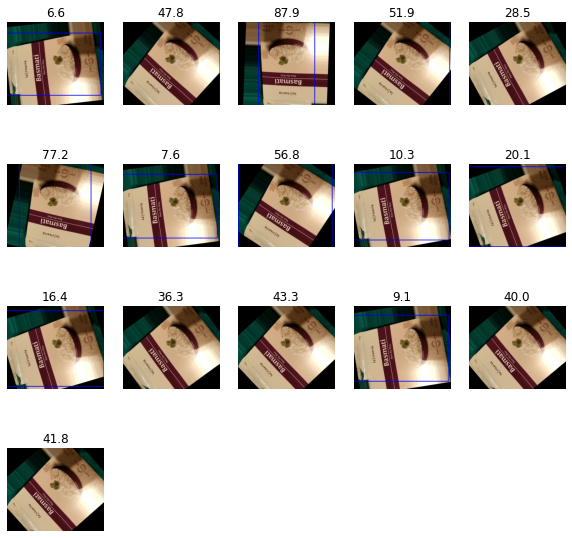

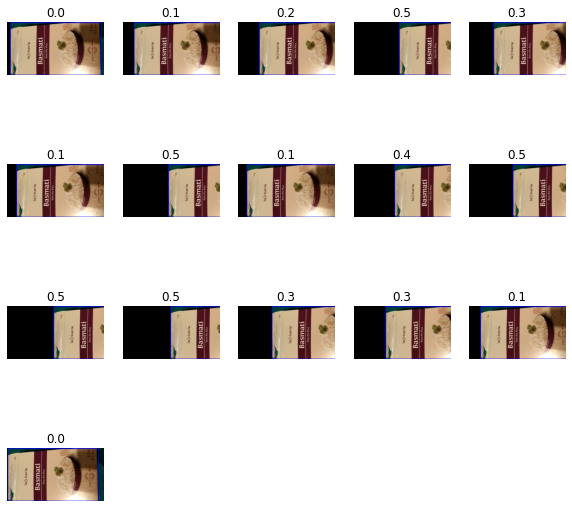

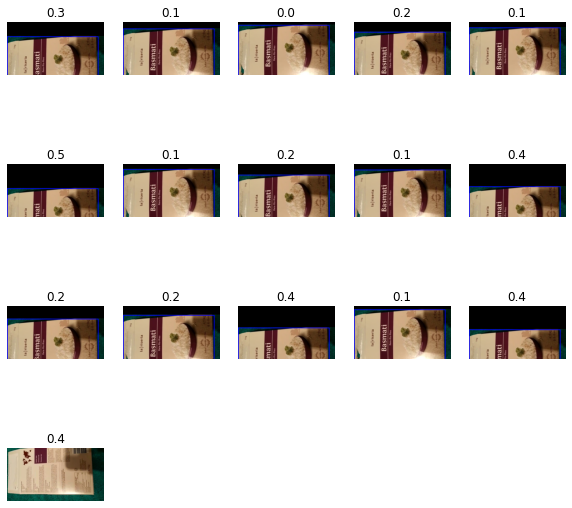

[57, -28, 529, 621]
[-36, 30, 612, 500]
[-18, -38, 593, 608]
[-35, 32, 612, 498]
[132, 5, 466, 599]
[116, -3, 479, 606]
[-41, -17, 614, 569]
[-43, -2, 616, 545]
[74, -22, 514, 618]
[-27, -35, 600, 600]
[19, -38, 560, 622]
[-5, 90, 589, 424]
[-24, 57, 603, 465]
[-42, -16, 615, 566]
[18, -38, 562, 621]
[-33, -31, 606, 591]
[112, 1, 695, 312]
[164, 1, 747, 312]
[142, 1, 725, 312]
[142, 1, 725, 312]
[78, 1, 661, 312]
[314, 1, 897, 312]
[195, 1, 778, 312]
[192, 1, 775, 312]
[172, 1, 755, 312]
[317, 1, 900, 312]
[260, 1, 843, 312]
[11, 1, 594, 312]
[99, 1, 682, 312]
[25, 1, 608, 312]
[5, 1, 588, 312]
[290, 1, 873, 312]
352
640
[1, 173, 584, 484]
1
352
352
640
[1, 107, 584, 418]
1
352
352
640
[1, 96, 584, 407]
1
352
352
640
[1, 123, 584, 434]
1
352
352
640
[1, 109, 584, 420]
1
352
352
640
[1, 30, 584, 341]
1
341
352
640
[1, 14, 584, 325]
1
325
352
640
[1, 101, 584, 412]
1
352
352
640
[1, 26, 584, 337]
1
337
352
640
[1, 82, 584, 393]
1
352
352
640
[1, 146, 584, 457]
1
352
352
640
[1, 71, 584, 

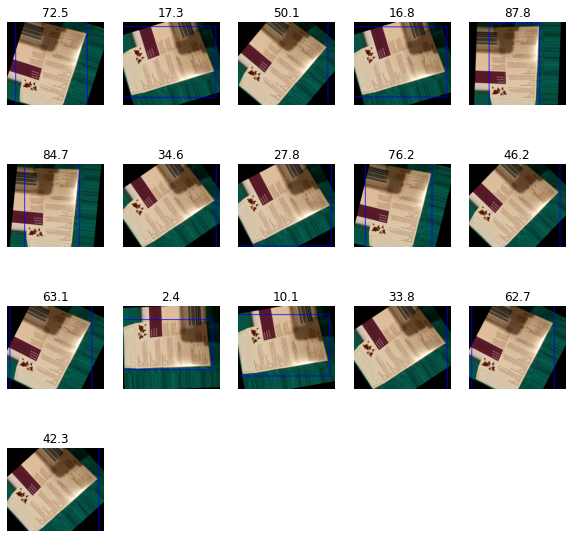

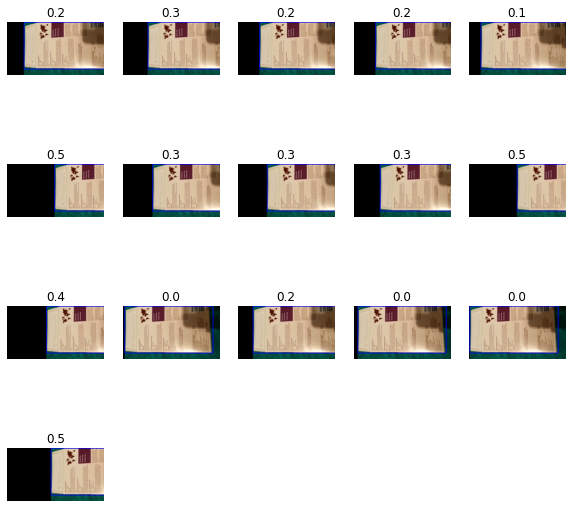

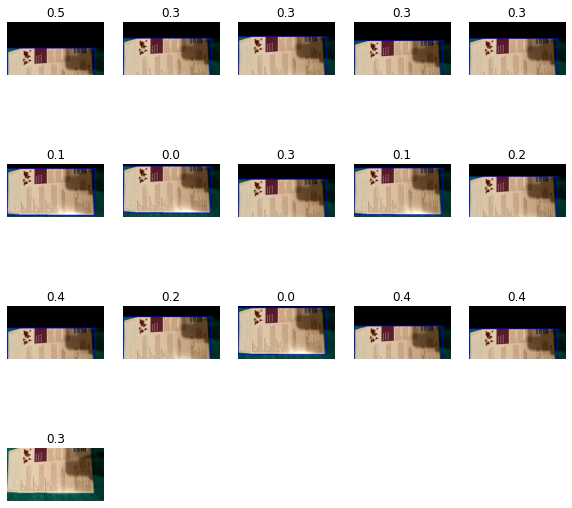

[-38, 22, 612, 504]
[-14, -39, 584, 604]
[-29, 48, 606, 470]
[-33, -29, 602, 582]
[17, -39, 556, 617]
[109, -7, 478, 608]
[-42, 0, 613, 536]
[21, -38, 552, 617]
[73, -23, 508, 616]
[83, -19, 500, 614]
[-13, 78, 595, 432]
[-32, 41, 608, 479]
[70, -24, 511, 617]
[-36, -25, 605, 576]
[-35, 33, 610, 490]
[32, -36, 543, 619]
[113, 3, 697, 303]
[122, 3, 706, 303]
[247, 3, 831, 303]
[19, 3, 603, 303]
[170, 3, 754, 303]
[280, 3, 864, 303]
[136, 3, 720, 303]
[111, 3, 695, 303]
[128, 3, 712, 303]
[138, 3, 722, 303]
[182, 3, 766, 303]
[261, 3, 845, 303]
[202, 3, 786, 303]
[97, 3, 681, 303]
[73, 3, 657, 303]
[93, 3, 677, 303]
352
640
[1, 166, 585, 466]
1
352
352
640
[1, 157, 585, 457]
1
352
352
640
[1, 89, 585, 389]
1
352
352
640
[1, 4, 585, 304]
1
304
352
640
[1, 36, 585, 336]
1
336
352
640
[1, 52, 585, 352]
1
352
352
640
[1, 112, 585, 412]
1
352
352
640
[1, 80, 585, 380]
1
352
352
640
[1, 94, 585, 394]
1
352
352
640
[1, 67, 585, 367]
1
352
352
640
[1, 85, 585, 385]
1
352
352
640
[1, 58, 585, 358

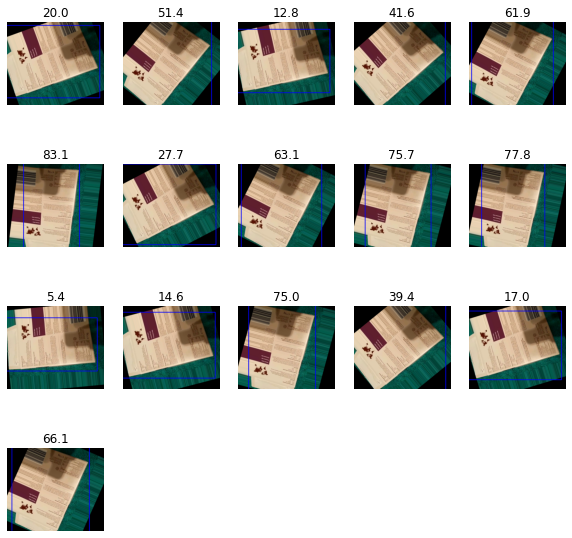

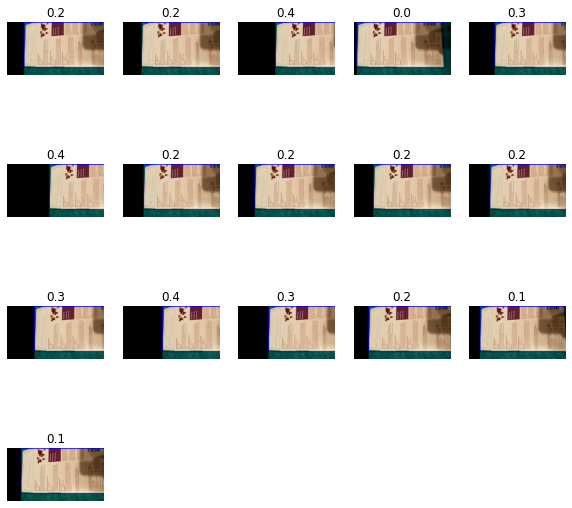

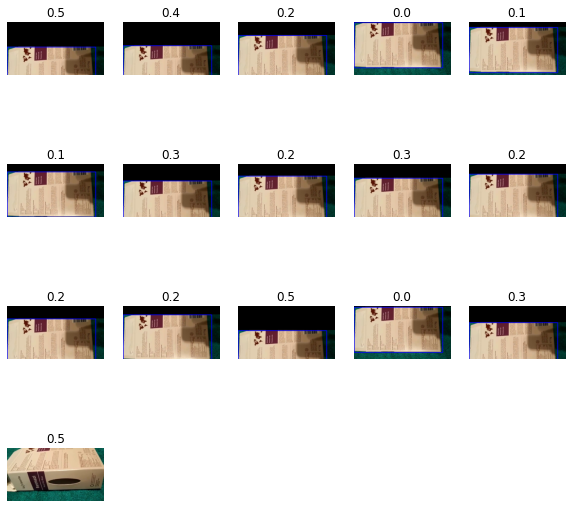

[27, -86, 566, 614]
[2, 98, 639, 402]
[-30, -69, 636, 582]
[-34, -62, 643, 573]
[117, -56, 471, 601]
[-6, -84, 606, 605]
[-14, -81, 615, 600]
[-9, 76, 646, 425]
[20, -86, 575, 613]
[-4, -84, 603, 606]
[-32, -66, 639, 578]
[3, -86, 594, 609]
[106, -61, 482, 605]
[-7, 79, 645, 421]
[112, -58, 477, 603]
[125, -52, 463, 599]
[129, 1, 763, 300]
[276, 1, 910, 300]
[149, 1, 783, 300]
[67, 1, 701, 300]
[269, 1, 903, 300]
[240, 1, 874, 300]
[18, 1, 652, 300]
[247, 1, 881, 300]
[238, 1, 872, 300]
[219, 1, 853, 300]
[309, 1, 943, 300]
[150, 1, 784, 300]
[208, 1, 842, 300]
[203, 1, 837, 300]
[164, 1, 798, 300]
[249, 1, 883, 300]
352
640
[4, 111, 638, 410]
4
352
352
640
[4, 95, 638, 394]
4
352
352
640
[4, 32, 638, 331]
4
331
352
640
[4, 36, 638, 335]
4
335
352
640
[4, 4, 638, 303]
4
303
352
640
[4, 143, 638, 442]
4
352
352
640
[4, 130, 638, 429]
4
352
352
640
[4, 141, 638, 440]
4
352
352
640
[4, 119, 638, 418]
4
352
352
640
[4, 79, 638, 378]
4
352
352
640
[4, 56, 638, 355]
4
352
352
640
[4, 100, 63

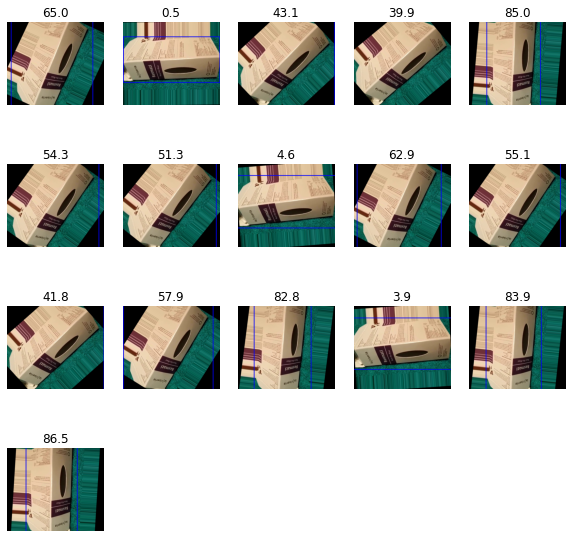

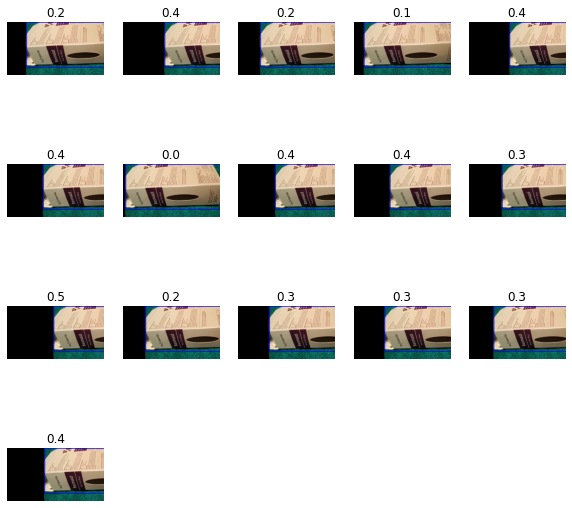

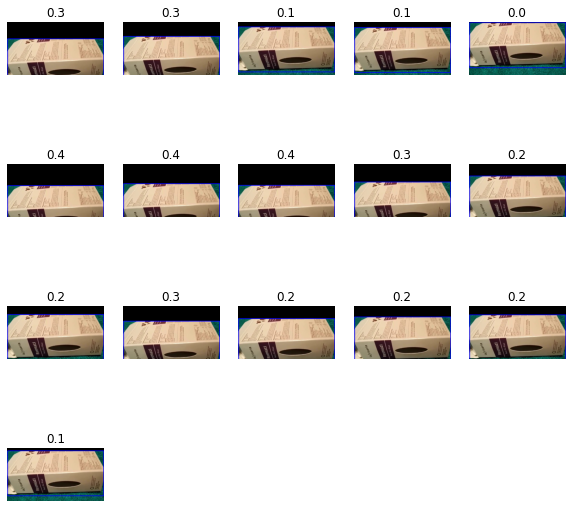

In [200]:

import os
import glob
import pandas as pd
import argparse
import xml.etree.ElementTree as ET
def xml_to_csv(path):
    """Iterates through all .xml files (generated by labelImg) in a given directory and combines them in a single Pandas datagrame.

    Parameters:
    ----------
    path : {str}
        The path containing the .xml files
    Returns
    -------
    Pandas DataFrame
        The produced dataframe
    """

    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        original_boundingbox=[]
        for member in root.findall('object'):
            image_path = path + "/"+root.find('filename').text
            width = int(root.find('size')[0].text)
            height = int(root.find('size')[1].text)
            x_min = int(member[4][0].text)
            y_min = int(member[4][1].text)
            x_max = int(member[4][2].text)
            y_max = int(member[4][3].text)
            value = (
                    #root.find('filename').text,
                    image_path,
                    x_min,
                    y_min,
                    x_max,
                    y_max 
                    )
            xml_list.append(value)
            original_boundingbox =[x_min, y_min, x_max, y_max]
        image_name = (root.find('filename').text).split(".")[0] 
        print (original_boundingbox)
        print( path + root.find('filename').text)
        original_image = u.read_image( path + "/"+root.find('filename').text)
        u.show_image(original_image)
        rotated_images = apply_transformation( original_image, original_boundingbox, "rotation", 16 )
        i = 0
        u.plot_images( rotated_images )
        for image in rotated_images:
            img_height, img_width = image[0].shape[:2]
            readimage = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)
            cv2.imwrite(path+ "/aug/" + image_name+ "_rotated_" + str(i) +".jpg", readimage)
            #tree = ET.parse("G:/image_proccessing/data_object_detection_sample/frame1.xml")
            #root = tree.getroot()
            print(image[1])
            root.find('filename').text = str(image_name+ "_rotated_" + str(i) +".jpg")
            root[6][4][0].text = str(image[1][0]) if image[1][0]> 0 else 0
            root[6][4][1].text = str(image[1][1]) if image[1][1]> 0 else 0
            root[6][4][2].text = str(image[1][2]) if image[1][2]< img_width else str(img_width)
            root[6][4][3].text = str(image[1][3]) if image[1][3]< img_height else str(img_height)
            tree.write(path+"/aug/" + image_name+ "_rotated_" + str(i) +".xml")
            
            i+=1
    
        w_shifted_images = apply_transformation( original_image, original_boundingbox, "width_shift", 16 )
        u.plot_images( w_shifted_images )
        i=0
        for image in w_shifted_images:
            img_height, img_width = image[0].shape[:2]
            convtimage = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)
            cv2.imwrite(path+ "/aug/" + image_name+ "_w_shifted_" + str(i) +".jpg", convtimage)
            #tree = ET.parse("G:/image_proccessing/data_object_detection_sample/frame1.xml")
            #root = tree.getroot()
            print(image[1])
            root.find('filename').text = str(image_name+ "_w_shifted_" + str(i) +".jpg")
            root[6][4][0].text = str(image[1][0]) if image[1][0]> 0 else 0
            root[6][4][1].text = str(image[1][1]) if image[1][1]> 0 else 0
            root[6][4][2].text = str(image[1][2]) if image[1][2]< img_width else str(img_width)
            root[6][4][3].text = str(image[1][3]) if image[1][3]< img_height else str(img_height)
            tree.write(path+"/aug/" + image_name+ "_w_shifted_" + str(i) +".xml")
            
            i+=1
        
        h_shifted_images = apply_transformation( original_image, original_boundingbox, "height_shift", 16 )

        i = 0
        u.plot_images( h_shifted_images )
        for image in h_shifted_images:
            img_height, img_width = image[0].shape[:2]
            print (img_height)
            print(img_width)
            convtimage = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)
            cv2.imwrite(path+ "/aug/" + image_name+ "_h_shifted_" + str(i) +".jpg", convtimage)
            #tree = ET.parse("G:/image_proccessing/data_object_detection_sample/frame1.xml")
            #root = tree.getroot()
            print(image[1])
            root.find('filename').text = str(image_name+ "_h_shifted_" + str(i) +".jpg")
            root[6][4][0].text = str(image[1][0]) if image[1][0]> 0 else 0
            print(root[6][4][0].text)
            root[6][4][1].text = str(image[1][1]) if image[1][1]> 0 else 0
            root[6][4][2].text = str(image[1][2]) if image[1][2]< img_width else str(img_width)
            root[6][4][3].text = str(image[1][3]) if image[1][3]< img_height else str(img_height)
            print(root[6][4][3].text)
            tree.write(path+ "/aug/" + image_name+ "_h_shifted_" + str(i) +".xml")
            
            i+=1
        
        
#         scaled_images = apply_transformation( original_image, original_boundingbox, "scale", 16 )
        
#         i = 0
        
#         for image in scaled_images:
#             convtimage = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)
#             cv2.imwrite(path + "/" + image_name+ "_scaled_" + str(i) +".jpg", convtimage)
#             #tree = ET.parse("G:/image_proccessing/data_object_detection_sample/frame1.xml")
#             #root = tree.getroot()
#             root[6][4][0].text = str(image[1][0]) 
#             root[6][4][1].text = str(image[1][1])
#             root[6][4][2].text = str(image[1][2])
#             root[6][4][3].text = str(image[1][3])
#             tree.write(path + "/" + image_name+ "_scaled_" + str(i) +".xml")
#             i+=1
    

xml_to_csv("G:\\image_proccessing\\data_object_detection_sample\\")


### Rotation

**Applying rotation transformation and visualizing results**

In [ ]:
#rotated_images = apply_transformation( original_image, original_boundingbox, "rotation", 16 )

In [ ]:
# i = 0
# u.plot_images( rotated_images )
# for image in rotated_images:
#     readimage = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)
#     cv2.imwrite("rotated" + str(i) +".jpg", readimage)
#     tree = ET.parse("G:/image_proccessing/data_object_detection_sample/frame1.xml")
#     root = tree.getroot()
#     print(image[1])
#     root[6][4][0].text = str(image[1][0])
#     root[6][4][1].text = str(image[1][1])
#     root[6][4][2].text = str(image[1][2])
#     root[6][4][3].text = str(image[1][3])
#     tree.write("rotated" + str(i) +".xml")
#     i+=1


### Width shift

**Applying width shift transformation and visualizing results**

In [62]:
#w_shifted_images = apply_transformation( original_image, original_boundingbox, "width_shift", 16 )

In [63]:
# i = 0
# u.plot_images( w_shifted_images )
# for image in w_shifted_images:
#         convtimage = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)
#         cv2.imwrite("shifted" + str(i) +".jpg", convtimage)
#         tree = ET.parse("G:/image_proccessing/data_object_detection_sample/frame1.xml")
#         root = tree.getroot()
#         print(image[1])
#         root[6][4][0].text = str(image[1][0])
#         root[6][4][1].text = str(image[1][1])
#         root[6][4][2].text = str(image[1][2])
#         root[6][4][3].text = str(image[1][3])
#         tree.write("shifted" + str(i) +".xml")
#         i+=1

### Height shift

**Applying height shift transformation and visualizing results**

In [ ]:
#h_shifted_images = apply_transformation( original_image, original_boundingbox, "height_shift", 16 )

In [18]:
# i = 0
# u.plot_images( h_shifted_images )
# for image in h_shifted_images:
#         convtimage = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)
#         cv2.imwrite("h_shifted" + str(i) +".jpg", convtimage)
#         tree = ET.parse("G:/image_proccessing/data_object_detection_sample/frame1.xml")
#         root = tree.getroot()
#         print(image[1])
#         root[6][4][0].text = str(image[1][0])
#         root[6][4][1].text = str(image[1][1])
#         root[6][4][2].text = str(image[1][2])
#         root[6][4][3].text = str(image[1][3])
#         tree.write("h_shifted" + str(i) +".xml")
#         i+=1

### Scaling

**Applying scale transformation and visualizing results**

In [139]:
#scaled_images = apply_transformation( original_image, original_boundingbox, "scale", 16 )

In [140]:
# o_h, o_w = original_image.shape[:2]
# for img in scaled_images:
#     h, w = img[0].shape[:2]
#     print( "Original size:", (o_w, o_h),  "  New size:", (w, h) )

Original size: (640, 352)   New size: (657, 361)
Original size: (640, 352)   New size: (773, 425)
Original size: (640, 352)   New size: (751, 413)
Original size: (640, 352)   New size: (471, 259)
Original size: (640, 352)   New size: (655, 360)
Original size: (640, 352)   New size: (804, 442)
Original size: (640, 352)   New size: (523, 288)
Original size: (640, 352)   New size: (870, 478)
Original size: (640, 352)   New size: (349, 192)
Original size: (640, 352)   New size: (494, 272)
Original size: (640, 352)   New size: (698, 383)
Original size: (640, 352)   New size: (416, 229)
Original size: (640, 352)   New size: (430, 236)
Original size: (640, 352)   New size: (328, 180)
Original size: (640, 352)   New size: (838, 461)
Original size: (640, 352)   New size: (551, 303)


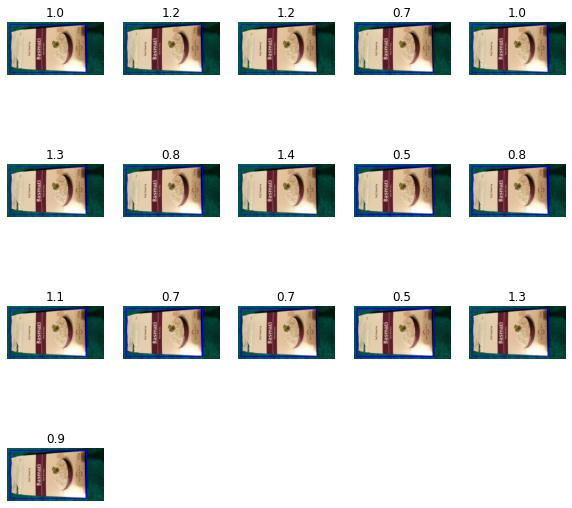

In [141]:
# i = 0
# u.plot_images( scaled_images )
# for image in scaled_images:
#         convtimage = cv2.cvtColor(image[0], cv2.COLOR_RGB2BGR)
#         cv2.imwrite("scaled" + str(i) +".jpg", convtimage)
#         tree = ET.parse("G:/image_proccessing/data_object_detection_sample/frame1.xml")
#         root = tree.getroot()
#         root[6][4][0].text = str(image[1][0])
#         root[6][4][1].text = str(image[1][1])
#         root[6][4][2].text = str(image[1][2])
#         root[6][4][3].text = str(image[1][3])
#         tree.write("scaled" + str(i) +".xml")
#         i+=1

### Reference:

* [Geometric Transformations of Images - OpenCv](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html)
* [Data Augmentation for Bounding Boxes: Rotation and Shearing](https://blog.paperspace.com/data-augmentation-for-object-detection-rotation-and-shearing/)